In [1]:
import pandas as pd
import numpy as np
import os

#import datetime as dt
from datetime import datetime
import pycountry as pc
import category_encoders as ce
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalFeatures

In [57]:
#### important: set train end year (e.g. if 2017, then test data starts from Jan 2018)

train_end = 2017
unit_of_analyis = 'isocode'

## Import and join data
We import the merged data set containing the target (deaths) and the covariates (GDELT event counts) alongside the World Bank's population data.
- We ensure both data sets start from 1989. 
- We ensure both data sets contain the same countries. As part of this process we eliminate several countries that rarely appear in GDELT.
- Missing values in the population: for 2022 and 2023 we use the population of 2021, only Palestine is missing data for 1989, so we impute the 1990 population

In [19]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

print('parent_path: ', parent_path)

merged_og = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))
wb_pop_og = pd.read_csv(os.path.abspath(parent_path + '/data/WorldBank_pop/wb_pop.csv'), sep=';') # NB in wide format
wb_pop_og.drop(columns=['Unnamed: 67', '2022', 'Indicator Name', 'Indicator Code'], inplace=True)
extra_pop = pd.read_csv(os.path.abspath(parent_path + '/data/TWN_ESH.csv'), sep=',') # We add population estimates for Taiwan and Western Sahara from a separate source

merged_og = merged_og[merged_og['year'] >= 1989]
extra_pop = extra_pop[extra_pop['year'] >= 1989]

print('countries with pop data: ',wb_pop_og['Country Code'].nunique())
print('countries in merged data: ',merged_og['isocode'].nunique())
print('extra pop countries: ',extra_pop['isocode'].nunique())


parent_path:  /Users/margheritaphilipp/Documents/GitHub/thesis
countries with pop data:  266
countries in merged data:  240
extra pop countries:  2


/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_14478/2784137331.py:6: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_og = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))


In [20]:
merged = merged_og.copy()

# Because of issue with MonthYear column: create new column with year and month
merged['year'] = merged['year'].astype(str)
merged['month'] = merged['month'].astype(str)

# Pad the month column with leading zeros if needed (e.g., convert '1' to '01')
merged['month'] = merged['month'].str.zfill(2)

# Concatenate the year and month columns with a '-' &  convert to datetime object
merged['month_year'] = merged['year'] + '-' + merged['month']
merged['month_year'] = pd.to_datetime(merged['month_year'], format='%Y-%m')


# compare month_year and MonthYear
merged.MonthYear = pd.to_datetime(merged.MonthYear)

print('entires merged:', len(merged))
print('date range:', merged.month_year.min(), 'to', merged.month_year.max())
# print('date range:', merged.MonthYear.min(), 'to', merged.MonthYear.max())

# merged[['month_year', 'MonthYear']].head(3)

entires merged: 92637
date range: 1989-01-01 00:00:00 to 2023-05-01 00:00:00


In [21]:
# Check which countries are in the GDELT-UCDP dataset but not in the World Bank population or the extra pop dataset
missing_pop_data = set(merged['isocode'].unique()) - set(wb_pop_og['Country Code'].unique()) - set(extra_pop['isocode'].unique())

print('Countries without population data (pre drop):', len(missing_pop_data))
for isoc in missing_pop_data:
    print(pc.countries.get(alpha_3=isoc).name)


# Drop rarely mentioned countries (with with <413 Month Entries in GDELT)
# exception: 'SSD'
isocodes_to_drop = ['ABW', 'AIA', 'AND', 'ASM', 'BVT', 'COK', 'CXR', 'CYM', 'FLK', 'FRO', 'GGY', 'GLP', 'GUF', 'HMD', 'IMN', 'IOT', 'KIR', 'KNA', 'LCA', 'LIE', 'MTQ', 'MYT', 'NFK', 'NIU', 'NRU', 'PCN', 'PLW', 'PYF', 'REU', 'SHN', 'SJM', 'SMR', 'SPM', 'TCA', 'TKL', 'TUV', 'VCT', 'VGB', 'WLF']
merged = merged[~merged['isocode'].isin(isocodes_to_drop)]

# Check missing counries again
missing_pop_data = set(merged['isocode'].unique()) - set(wb_pop_og['Country Code'].unique()) - set(extra_pop['isocode'].unique())

print('___________________________________________________________')
print('Countries without population data (post drop):', len(missing_pop_data))

for isoc in missing_pop_data:
    print(pc.countries.get(alpha_3=isoc).name)

Countries without population data (pre drop): 25
Niue
Svalbard and Jan Mayen
Cook Islands
Saint Pierre and Miquelon
British Indian Ocean Territory
Wallis and Futuna
Anguilla
Tokelau
Falkland Islands (Malvinas)
Guadeloupe
Bouvet Island
Saint Helena, Ascension and Tristan da Cunha
Heard Island and McDonald Islands
French Guiana
Jersey
Martinique
Norfolk Island
Antarctica
Pitcairn
Réunion
Christmas Island
Montserrat
Guernsey
Holy See (Vatican City State)
Mayotte
___________________________________________________________
Countries without population data (post drop): 4
Jersey
Antarctica
Holy See (Vatican City State)
Montserrat


In [22]:
# Drop the remaining countries without population data - no longer having to drop Western Sahara and Taiwan
isocodes_to_drop = ['ATA', 'JEY', 'MSR', 'VAT'] #'ESH' 'TWN'
merged = merged[~merged['isocode'].isin(isocodes_to_drop)]

In [23]:
# After March 2023, no deaths present - so assume not matched to UCDP data and not used
for date in ['2023-02-01','2023-03-01', '2023-04-01', '2023-05-01']:
    print(f'countries: in {date}: ', len(merged[merged['month_year'] == date]['deaths']))
    print('of which nan deaths:      ',merged[merged['month_year'] == date]['deaths'].isnull().sum())

countries: in 2023-02-01:  197
of which nan deaths:       174
countries: in 2023-03-01:  197
of which nan deaths:       153
countries: in 2023-04-01:  197
of which nan deaths:       197
countries: in 2023-05-01:  197
of which nan deaths:       197


## Impute rows for missing months
We want a complete set of months between the first and the final mention of a country in our dataset. At the end we verify that we have the expected number of months for each country.



In [24]:
#df_fill = df_merged.copy()
df_fill = merged.copy() 

In [25]:
# 'year' and 'month' columns to a datetime type
df_fill['date'] = pd.to_datetime(df_fill[['year', 'month']].assign(day=1))

# columns to be filled
fill_cols = [col for col in df_fill.columns if 'events' in col] # previously 'counts', but that missed teh normalised total event

dfs = []

# Iterate through unique 'isocode' values
for isocode in df_fill['isocode'].unique():
    df_isocode = df_fill[df_fill['isocode'] == isocode].copy()

    # Create a new dataframe that covers all months between the min and max 'Date' for this isocode
    min_date = df_isocode['date'].min()
    max_date = df_isocode['date'].max()
    all_dates = pd.DataFrame(pd.date_range(min_date, max_date, freq='MS'), columns=['date'])

    # merge onto the existing dataframe
    df_isocode = pd.merge(all_dates, df_isocode, on='date', how='left')

    df_isocode['isocode'] = isocode

    # forward-fill and then fill any remaining NaNs with 0
    df_isocode[fill_cols] = df_isocode[fill_cols].ffill().fillna(0)

    # convert the 'date' back to 'year' and 'month'
    df_isocode['year'] = df_isocode['date'].dt.year
    df_isocode['month'] = df_isocode['date'].dt.month

    # append to list
    dfs.append(df_isocode)

# concatenate all DataFrames in the list into a final DataFrame
df_filled = pd.concat(dfs)

#df_final.drop(columns=['date'], inplace=True)

# sort final dataframe by 'isocode', 'year' and 'month'
df_filled.sort_values(['year', 'month', 'isocode'], inplace=True)
df_filled.fillna(0)

df_filled.drop(columns=['MonthYear'], inplace=True)

In [26]:
def get_country_name(iso_code):
    try:
        return pc.countries.get(alpha_3=iso_code).name
    except AttributeError:
        return None

df_filled['country'] = df_filled['isocode'].apply(get_country_name)

In [27]:
def check_month_year_sequence(group):
    # Create the expected sequence of months and years
    min_year, min_month = group[['year', 'month']].iloc[0] # use the first row of each group
    max_year, max_month = group[['year', 'month']].iloc[-1] # use the last row of each group

    expected_month_years = [(y, m) for y in range(min_year, max_year + 1) for m in range(1, 13)]
    
    # If there is only one year in the data, filter for months within the min and max range
    if min_year == max_year:
        expected_month_years = [my for my in expected_month_years if min_month <= my[1] <= max_month]
    else:
        # If there are multiple years, adjust for the first and last years
        expected_month_years = [my for my in expected_month_years if 
                                not (my[0] == min_year and my[1] < min_month) and 
                                not (my[0] == max_year and my[1] > max_month)]
                                
    # Check if the sequence of month-years in the group is equal to the expected sequence
    actual_month_years = sorted(list(zip(group['year'], group['month'])))
    
    if actual_month_years != expected_month_years:
        print(f"Incorrect sequence for isocode: {group['isocode'].iloc[0]}")
        print(f"Expected: {expected_month_years}")
        print(f"Actual: {actual_month_years}")
        
    return actual_month_years == expected_month_years


In [28]:
# Apply the function to each group
is_sequence_correct = df_filled.groupby('isocode').apply(check_month_year_sequence)

# Check if the sequence of month-years is correct for all isocodes
assert is_sequence_correct.all(), "The sequence of month-years is not correct for some isocodes"

# check how many rows added
print('Rows added:', len(df_filled) - len(df_fill))

Rows added: 652


## Population data 

### Melt WB data into long format 
Fill 2022 and 2023 with 2021 population value and cut off at 1989.

In [29]:
pop = wb_pop_og.copy()
# fill missing complete years (in future to be replaces on basis of growth rate)
pop['2022'] = pop['2021']
pop['2023'] = pop['2021']
pop.head(3)

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106537.0,106537.0
1,Africa Eastern and Southern,AFE,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,...,583650827.0,600008150.0,616377331.0,632746296.0,649756874.0,667242712.0,685112705.0,702976832.0,702976832.0,702976832.0
2,Afghanistan,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,40099462.0,40099462.0


In [30]:
# We realised that Palestine is missing population data for 1989 and impute it with 1990 values
missing_1989 = pop[pop['1989'].isnull()]
missing_1989['1989'] = missing_1989['1990']

# Update the original DataFrame with the imputed values
pop.update(missing_1989)
#pop[pop['1989'].isnull()] # only INX which doesn't seem to be a country
county_to_drop = ['INX']
pop = pop[~pop['Country Code'].isin(county_to_drop)]

# melt population data
pop = pd.melt(pop, id_vars=('Country Code', 'Country Name'), var_name='Year', value_name='wb_pop')

pop.rename(columns={'Country Code': 'isocode'}, inplace=True)
pop.rename(columns={'Year': 'year'}, inplace=True)
pop = pop[pop['year'] >= '1989']


# checks
print(pop.year.min(), pop.year.max())
pop.isnull().sum()

1989 2023


/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_14478/1161258014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_1989['1989'] = missing_1989['1990']


isocode         0
Country Name    0
year            0
wb_pop          0
dtype: int64

### Interpolate missing years for extra population data
Western Sahara and Taiwan

In [31]:
all_years = np.arange(1989, 2024)

extra_pop_all = pd.DataFrame()
for isocode in extra_pop['isocode'].unique():
    # Create a new data frame with all possible years
    complete_group = pd.DataFrame({'year': all_years, 'isocode': isocode})
    # Merge the original data frame with the complete group based on isocode and year
    merged_group = pd.merge(complete_group, extra_pop, on=['isocode', 'year'], how='left')
    # Perform linear interpolation within the group
    merged_group['population'] = merged_group['population'].interpolate(method='linear')
    # Forward fill and backward fill any remaining missing values
    merged_group['population'] = merged_group['population'].ffill().bfill()
    # Add the complete group to the final data frame
    extra_pop_all = pd.concat([extra_pop_all, merged_group])

# Sort the complete data frame by isocode and year
extra_pop_all.sort_values(['isocode', 'year'], inplace=True)

extra_pop_all.rename(columns={'population': 'wb_pop'}, inplace=True)

extra_pop_all.drop(columns=['Country Name'], inplace=True)
print('Rows added:', len(extra_pop_all) - len(extra_pop))
print(extra_pop_all.year.min(), extra_pop_all.year.max())
extra_pop_all.isnull().sum()

Rows added: 46
1989 2023


year       0
isocode    0
wb_pop     0
dtype: int64

### Visualisations
Shows that population distributions change depending on which years are taken into account. Although year-on-year percentage changes are close to zero for most countries.

/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_14478/3429706013.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['year'].astype(int)


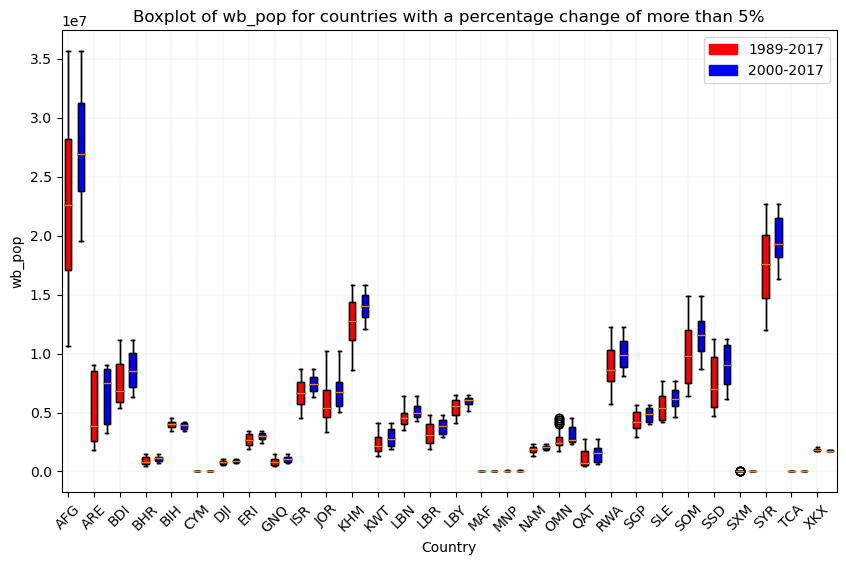

In [32]:
selected_isocodes = ["AFG", "ARE", "BDI", "BHR", "BIH", "CYM", "DJI", "ERI", "GNQ", "ISR", "JOR", "KHM", "KWT", "LBN", "LBR", "LBY", "MAF", "MNP", "NAM", "OMN", "QAT", "RWA", "SGP", "SLE", "SOM", "SSD", "SXM", "SYR", "TCA", "XKX"]

# "AFG", "ARE", "BDI", "BHR", "BIH", "CYM", "DJI", "ERI", "GNQ", "ISR", "JOR", "KHM", "KWT", "LBN", "LBR", "LBY", "MAF", "MNP", "NAM", "OMN", "QAT", "RWA", "SGP", "SLE", "SOM", "SSD", "SXM", "SYR", "TCA", "XKX"
filtered_data = pop[pop['isocode'].isin(selected_isocodes)]


# Filter the data for the two time periods: 1989 vs 2000 until end of train 
filtered_data['year'] = filtered_data['year'].astype(int)

data_1989_train_end = filtered_data[(filtered_data['year'] >= 1989) & (filtered_data['year'] <= train_end)]
#data_2000_2022 = filtered_data[(filtered_data['year'] >= 2000) & (filtered_data['year'] <= 2022)]
data_2000_train_end = filtered_data[(filtered_data['year'] >= 2000) & (filtered_data['year'] <= train_end)]

# Create a list to store the labels for each country
labels = []
colors = []
data_combined = []
for isocode in selected_isocodes:
    labels.append(isocode)
    labels.append('')
    colors.extend(['red', 'blue']) #'green'
    data_combined.append(data_1989_train_end[data_1989_train_end['isocode'] == isocode]['wb_pop'])
    #data_combined.append(data_2000_2022[data_2000_2022['isocode'] == isocode]['wb_pop'])
    data_combined.append(data_2000_train_end[data_2000_train_end['isocode'] == isocode]['wb_pop'])

# Create the boxplot using matplotlib
plt.figure(figsize=(10, 6))
plt.boxplot(data_combined, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            capprops=dict(color='black'), whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'), medianprops=dict(color='black'))

for patch, color in zip(plt.boxplot(data_combined, patch_artist=True)['boxes'], colors):
    patch.set_facecolor(color)
    
# Create a legend for the time period colors
legend_elements = [plt.Rectangle((0, 0), 1, 1, color='red', label=f'1989-{train_end}'),
                   #plt.Rectangle((0, 0), 1, 1, color='blue', label='2000-2022'),
                   plt.Rectangle((0, 0), 1, 1, color='blue', label=f'2000-{train_end}')
                   ]
plt.legend(handles=legend_elements, loc='upper right')

plt.title('Boxplot of wb_pop for countries with a percentage change of more than 5%')
plt.xlabel('Country')
plt.ylabel('wb_pop')
plt.grid(color='grey', linestyle='--', linewidth=0.1)
plt.xticks(np.arange(1, len(selected_isocodes) * 2, 2), selected_isocodes, rotation= 45)
plt.show()

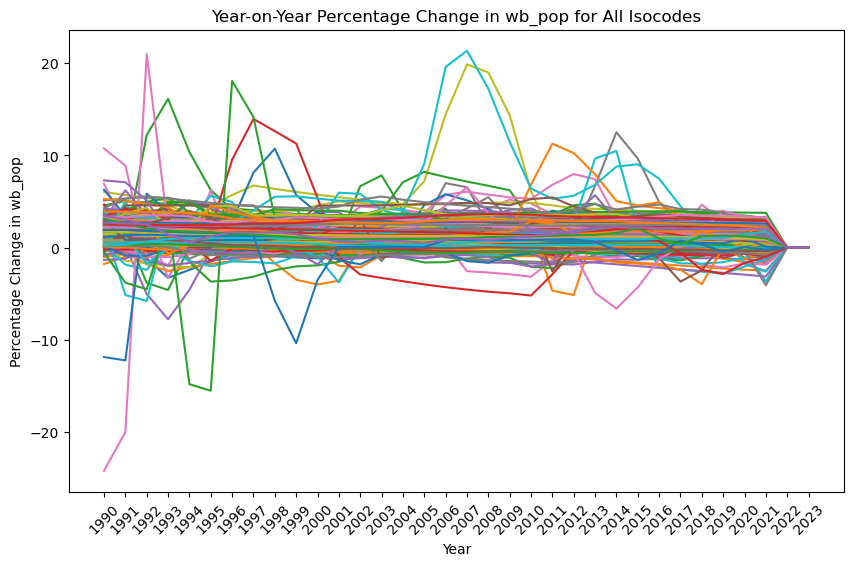

In [33]:
# Calculate the year-on-year percentage change for each isocode
pop['pct_change'] = pop.groupby('isocode')['wb_pop'].pct_change() * 100

# Create a separate line plot for each country
fig, ax = plt.subplots(figsize=(10, 6))
for isocode, data in pop.groupby('isocode'):
    ax.plot(data['year'], data['pct_change'], label=isocode)

# Set the legend outside the graph
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percentage Change in wb_pop')
ax.set_title('Year-on-Year Percentage Change in wb_pop for All Isocodes')
plt.xticks(np.arange(1, pop.year.nunique()), rotation=45)

pop.drop(columns=['pct_change'], inplace=True)

# Display the plot
plt.show()


### Option 1: work with averages
IMPORTANT: Decide when training data ends!

In [34]:
train_end = 2017

In [35]:
print(pop.isnull().sum().sum())

0


In [36]:
pop['year'] = pop['year'].astype(int)

# Filter the dataframe for the desired years (2020-train_end) / (1989-train_end))
pop_2000_to_train_end = pop[pop['year'].between(2000, train_end)]
pop_1989_to_train_end = pop[pop['year'].between(1989, train_end)]

# Group by 'isocode' and 'Country Name' columns and calculate the average population
grouped_2000_to_train_end = pop_2000_to_train_end.groupby(['isocode', 'Country Name'])['wb_pop'].mean().reset_index()
grouped_1989_to_train_end = pop_1989_to_train_end.groupby(['isocode', 'Country Name'])['wb_pop'].mean().reset_index()

# Merge & rename the columns
pop_avrg = pd.merge(grouped_1989_to_train_end, grouped_2000_to_train_end, on=['isocode', 'Country Name'], suffixes=(f'_1989_{train_end}', f'_2000_{train_end}'), how = 'left')
pop_avrg.rename(columns={f'wb_pop_2000_{train_end}': f'av_pop_2000_{train_end}', f'wb_pop_1989_{train_end}': f'av_pop_1989_{train_end}'}, inplace=True)

########
# same for taiwan and western sahara
extra_pop_all['year'] = extra_pop_all['year'].astype(int)

# Filter the dataframe for the desired years (2020-train_end) / (1989-train_end))
extra_pop_2000_to_train_end = extra_pop[extra_pop['year'].between(2000, train_end)]
extra_pop_1989_to_train_end = extra_pop[extra_pop['year'].between(1989, train_end)]

# Group by 'isocode' and 'Country Name' columns and calculate the average population
grouped_2000_to_train_end = extra_pop_2000_to_train_end.groupby(['isocode', 'Country Name'])['population'].mean().reset_index()
grouped_1989_to_train_end = extra_pop_1989_to_train_end.groupby(['isocode', 'Country Name'])['population'].mean().reset_index()

# Merge & rename the columns
extra_pop_avrg = pd.merge(grouped_1989_to_train_end, grouped_2000_to_train_end, on=['isocode', 'Country Name'], suffixes=(f'_1989_{train_end}', f'_2000_{train_end}'))
extra_pop_avrg.rename(columns={f'population_2000_{train_end}': f'av_pop_2000_{train_end}', f'population_1989_{train_end}': f'av_pop_1989_{train_end}'}, inplace=True)


### join them 
pop_avrg_all = pd.concat([pop_avrg, extra_pop_avrg], ignore_index=True)
pop_avrg_all

,isocode,Country Name,av_pop_1989_2017,av_pop_2000_2017
0,ABW,Aruba,8.936772e+04,9.814906e+04
1,AFE,Africa Eastern and Southern,4.462987e+08,5.080066e+08
2,AFG,Afghanistan,2.258264e+07,2.734424e+07
3,AFW,Africa Western and Central,3.015882e+08,3.449816e+08
4,AGO,Angola,1.914074e+07,2.255819e+07
...,...,...,...,...
262,ZAF,South Africa,4.816150e+07,5.130681e+07
263,ZMB,Zambia,1.146231e+07,1.326757e+07
264,ZWE,Zimbabwe,1.212194e+07,1.289465e+07
265,ESH,Western Sahara,2.247047e+07,2.305026e+07


In [38]:
# Merge population data with GDELT-UCDP data
df_merged_av_pop = pd.merge(merged, pop_avrg_all, on=['isocode'], how='left')

#df_merged_av_pop.drop(columns=['country'], inplace=True)
df_merged_av_pop['year'] = df_merged_av_pop['year'].astype(int)
df_pop_average = df_merged_av_pop[df_merged_av_pop['year'] >= 2000]

### Option 2: work with imputed changes


In [39]:
pop2 = pop.copy()
xpop2 = extra_pop_all.copy()

In [40]:
# Join extra data with world bank data
all_pop = pd.concat([pop2, xpop2], ignore_index=True)
all_pop.sort_values(['year', 'isocode'], inplace=True)

# Convert year column to datetime &  set the month and day to 1st of January
all_pop['month_year'] = pd.to_datetime(all_pop['year'], format='%Y')
all_pop['month_year'] = all_pop['month_year'].dt.strftime('%Y-%m-%d')
all_pop

,isocode,Country Name,year,wb_pop,month_year
0,ABW,Aruba,1989,64596.0,1989-01-01
1,AFE,Africa Eastern and Southern,1989,301124880.0,1989-01-01
2,AFG,Afghanistan,1989,10673168.0,1989-01-01
3,AFW,Africa Western and Central,1989,201392200.0,1989-01-01
4,AGO,Angola,1989,11439498.0,1989-01-01
...,...,...,...,...,...
9270,XKX,Kosovo,2023,1786038.0,2023-01-01
9271,YEM,"Yemen, Rep.",2023,32981641.0,2023-01-01
9272,ZAF,South Africa,2023,59392255.0,2023-01-01
9273,ZMB,Zambia,2023,19473125.0,2023-01-01


In [41]:
merged['month_year'] = pd.to_datetime(merged['month_year'], format='%Y-%m-%d')
merged['month_year'] = merged['month_year'].dt.strftime('%Y-%m-%d')
all_pop.drop(columns=['year'], inplace=True)
trial = pd.merge(merged, all_pop, on=['isocode', 'month_year'], how='left')

In [42]:
trial.loc[trial['isocode'] == 'TWN']

,MonthYear,isocode,month,year,count_events_1,count_events_2,count_events_3,count_events_4,count_events_5,count_events_6,...,count_events_20_opp,country,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop
172,1970-01-01 00:00:00.000198901,TWN,01,1989,10.0,4.0,14.0,38.0,12.0,6.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-01-01,NaN,178529.0
359,1970-01-01 00:00:00.000198902,TWN,02,1989,20.0,14.0,20.0,60.0,4.0,4.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-02-01,NaN,NaN
547,1970-01-01 00:00:00.000198903,TWN,03,1989,34.0,28.0,28.0,70.0,14.0,6.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-03-01,NaN,NaN
735,1970-01-01 00:00:00.000198904,TWN,04,1989,26.0,16.0,44.0,92.0,26.0,8.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-04-01,NaN,NaN
925,1970-01-01 00:00:00.000198905,TWN,05,1989,22.0,10.0,44.0,154.0,38.0,12.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-05-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79886,1970-01-01 00:00:00.000202301,TWN,01,2023,2438.0,1080.0,1642.0,5020.0,1570.0,588.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01,NaN,587259.0
80083,1970-01-01 00:00:00.000202302,TWN,02,2023,2258.0,972.0,2230.0,5902.0,1678.0,670.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-01,NaN,NaN
80280,1970-01-01 00:00:00.000202303,TWN,03,2023,3744.0,1856.0,4680.0,13246.0,3486.0,870.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-01,NaN,NaN
80477,1970-01-01 00:00:00.000202304,TWN,04,2023,6974.0,3234.0,7010.0,28562.0,5346.0,1596.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-01,NaN,NaN


In [43]:
# Convert 'month_year' column to datetime type
trial['month_year'] = pd.to_datetime(trial['month_year'])

# Set 'isocode' and 'month_year' as the index
trial = trial.set_index(['isocode', 'month_year'])

# Function to interpolate missing values within a group
def interpolate_group(group):
    group['wb_pop'] = group['wb_pop'].interpolate(method='linear')
    return group

# Apply interpolation within each country group
trial = trial.groupby('isocode').apply(interpolate_group)

# Reset the index
trial = trial.reset_index(drop=False)

# # Filter the DataFrame to include only the desired range of months
# start_date = pd.to_datetime('2020-01-01')
# end_date = pd.to_datetime('2022-12-31')
# trial = trial[(trial['month_year'] >= start_date) & (trial['month_year'] <= end_date)]


/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_14478/865657044.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  trial = trial.groupby('isocode').apply(interpolate_group)


In [44]:
# NB from Jan 2021 onwards there will be no more changes as 2021 is the final year we have changing population data for
trial.loc[trial['isocode'] == 'AFG', ['month_year', 'wb_pop']][-55:-22]

,month_year,wb_pop
69856,2018-11-01,3.758905e+07
70053,2018-12-01,3.767927e+07
70250,2019-01-01,3.776950e+07
70447,2019-02-01,3.786973e+07
70644,2019-03-01,3.796995e+07
70841,2019-04-01,3.807018e+07
71038,2019-05-01,3.817041e+07
71235,2019-06-01,3.827064e+07
71432,2019-07-01,3.837086e+07
71629,2019-08-01,3.847109e+07


In [45]:
print('number of missing population values:', trial['wb_pop'].isnull().sum())
print('all missing population values are before', trial[trial['wb_pop'].isnull()].year.max())
print('countries: ', trial[trial['wb_pop'].isnull()].isocode.unique())

number of missing population values: 101
all missing population values are before 1991
countries:  ['COM' 'ISL' 'STP' 'TON' 'DMA' 'GNQ' 'MCO' 'MHL' 'WSM']


In [46]:
trial.drop(columns=['country'], inplace=True)
trial['year'] = trial['year'].astype(int)
df_pop_interpolated = trial[trial['year'] >= 2000]

### Combine both options

In [47]:
# check dimensions are the same
print(df_pop_interpolated.shape, df_pop_average.shape)
print(df_pop_interpolated.isocode.nunique(), df_pop_average.isocode.nunique())

# have both options available
pop_options =  df_pop_average.copy()
pop_options['intp_pop'] =  df_pop_interpolated['wb_pop']
print('nulls:',pop_options.isnull().sum().sum(), '(mainly from deaths and event shares)')
pop_options.loc[pop_options['isocode'] == 'AFG', ['isocode', 'month_year', 'intp_pop', f'av_pop_2000_{train_end}', f'av_pop_1989_{train_end}']]


(55309, 72) (55309, 74)
197 197
nulls: 277998 (mainly from deaths and event shares)


,isocode,month_year,intp_pop,av_pop_2000_2017,av_pop_1989_2017
25382,AFG,2000-01-01,19542982.0,2.734424e+07,2.258264e+07
25578,AFG,2000-02-01,19555119.5,2.734424e+07,2.258264e+07
25775,AFG,2000-03-01,19567257.0,2.734424e+07,2.258264e+07
25972,AFG,2000-04-01,19579394.5,2.734424e+07,2.258264e+07
26168,AFG,2000-05-01,19591532.0,2.734424e+07,2.258264e+07
...,...,...,...,...,...
79706,AFG,2023-01-01,40099462.0,2.734424e+07,2.258264e+07
79903,AFG,2023-02-01,40099462.0,2.734424e+07,2.258264e+07
80100,AFG,2023-03-01,40099462.0,2.734424e+07,2.258264e+07
80297,AFG,2023-04-01,40099462.0,2.734424e+07,2.258264e+07


## Conflict definition(s)
Calculate deaths per 100,000 based on different population calculations.

Missing UCDP data: means no deaths for tracked dyads occured - assume zero casualties.

In [48]:
df_conf = pop_options.copy()

In [49]:
# fill missing deaths with 0
death_columns = ['deaths', 'state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths']
df_conf[death_columns] = df_conf[death_columns].fillna(0)

In [50]:
# generate deaths per 100,000 people for different population counts
population_versions = [f'av_pop_1989_{train_end}', f'av_pop_2000_{train_end}','intp_pop' ]

for wb_pop in population_versions:
    df_conf[f'deaths_all_{wb_pop}_pc'] = df_conf['deaths'] /  df_conf[wb_pop] *100_000
    #df_conf[f'deaths_state_{wb_pop}_pc'] = df_conf['state_deaths'] /  df_conf[wb_pop] *100_000
    

#df_conf['deaths_all_pc'] = df_conf['deaths'] /  df_conf['wb_pop'] *100_000
#df_conf['deaths_state_pc'] = df_conf['deaths'] /  df_conf['wb_pop'] *100_000

In [51]:
# generate conflict dummy variables based on thresholds

for wb_pop in population_versions:
    df_conf[f'armedconf_{wb_pop}'] = df_conf[f'deaths_all_{wb_pop}_pc']>0.05 # more than 0.05 deaths per 100,000 people, i.e. 2 per 1 million 
    df_conf[f'civilwar_{wb_pop}'] = df_conf[f'deaths_all_{wb_pop}_pc']>3

# df_conf['armedconf'] = df_conf.deaths_all_pc>0.05
# df_conf['civilwar'] = df_conf.deaths_all_pc>3

In [52]:
country_df = df_conf[df_conf['Country Name'] == 'Afghanistan']
country_df[['Country Name','month_year', f'av_pop_1989_{train_end}', f'av_pop_2000_{train_end}','intp_pop',
        f'deaths_all_av_pop_1989_{train_end}_pc', f'deaths_all_av_pop_2000_{train_end}_pc', 'deaths_all_intp_pop_pc',
       f'armedconf_av_pop_1989_{train_end}',  f'armedconf_av_pop_2000_{train_end}', 'armedconf_intp_pop',
       f'civilwar_av_pop_1989_{train_end}', f'civilwar_av_pop_2000_{train_end}', 'civilwar_intp_pop']]

,Country Name,month_year,av_pop_1989_2017,av_pop_2000_2017,intp_pop,deaths_all_av_pop_1989_2017_pc,deaths_all_av_pop_2000_2017_pc,deaths_all_intp_pop_pc,armedconf_av_pop_1989_2017,armedconf_av_pop_2000_2017,armedconf_intp_pop,civilwar_av_pop_1989_2017,civilwar_av_pop_2000_2017,civilwar_intp_pop
25382,Afghanistan,2000-01-01,2.258264e+07,2.734424e+07,19542982.0,0.239122,0.197482,0.276314,True,True,True,False,False,False
25578,Afghanistan,2000-02-01,2.258264e+07,2.734424e+07,19555119.5,0.673083,0.555876,0.777290,True,True,True,False,False,False
25775,Afghanistan,2000-03-01,2.258264e+07,2.734424e+07,19567257.0,1.403733,1.159293,1.620053,True,True,True,False,False,False
25972,Afghanistan,2000-04-01,2.258264e+07,2.734424e+07,19579394.5,2.346936,1.938251,2.706927,True,True,True,False,False,False
26168,Afghanistan,2000-05-01,2.258264e+07,2.734424e+07,19591532.0,0.363111,0.299880,0.418548,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79706,Afghanistan,2023-01-01,2.258264e+07,2.734424e+07,40099462.0,0.000000,0.000000,0.000000,False,False,False,False,False,False
79903,Afghanistan,2023-02-01,2.258264e+07,2.734424e+07,40099462.0,0.000000,0.000000,0.000000,False,False,False,False,False,False
80100,Afghanistan,2023-03-01,2.258264e+07,2.734424e+07,40099462.0,0.221409,0.182854,0.124690,True,True,True,False,False,False
80297,Afghanistan,2023-04-01,2.258264e+07,2.734424e+07,40099462.0,0.000000,0.000000,0.000000,False,False,False,False,False,False


In [53]:
column_list = [f'armedconf_av_pop_1989_{train_end}',  f'armedconf_av_pop_2000_{train_end}', 'armedconf_intp_pop',
       f'civilwar_av_pop_1989_{train_end}', f'civilwar_av_pop_2000_{train_end}', 'civilwar_intp_pop']

true_counts = df_conf[column_list].sum()
total_counts = df_conf[column_list].count()
percentage_true = (true_counts / total_counts) * 100

summary_table = pd.DataFrame({'True Count': true_counts , 'Percentage True': percentage_true}) #'Column': column_list, 
print(summary_table)

# in current preprocessing: df_og.armedconf.sum() = 7144

                            True Count  Percentage True
armedconf_av_pop_1989_2017        4842         8.754452
armedconf_av_pop_2000_2017        4687         8.474209
armedconf_intp_pop                4594         8.306062
civilwar_av_pop_1989_2017          456         0.824459
civilwar_av_pop_2000_2017          386         0.697897
civilwar_intp_pop                  345         0.623768


In [54]:
df_conf.loc[df_conf['isocode']=='TWN', f'armedconf_av_pop_1989_{train_end}'].sum()

0

## Past deaths and periods of peace
Important: decide which population and conflict definition to go with!
NB: Hannes used the total number of deaths rather than the deaths per capita


In [55]:
df_past = df_conf.copy()

pop_choice = 'intp_pop'
deaths_choice = f'deaths_all_{pop_choice}_pc'
conflict_choice = f'armedconf_{pop_choice}'


### Drop everything that was not chosen

not_chosen_pops = [x for x in population_versions if x != pop_choice]

for not_picked in not_chosen_pops:
    print('dropping :', f'deaths_all_{not_picked}_pc', f'armedconf_{not_picked}', not_picked)
    df_past.drop(columns=[f'deaths_all_{not_picked}_pc', f'armedconf_{not_picked}', not_picked], inplace=True)

for vers in population_versions:
    print('dropping :', f'civilwar_{vers}')
    df_past.drop(columns=f'civilwar_{vers}', inplace=True)

dropping : deaths_all_av_pop_1989_2017_pc armedconf_av_pop_1989_2017 av_pop_1989_2017
dropping : deaths_all_av_pop_2000_2017_pc armedconf_av_pop_2000_2017 av_pop_2000_2017
dropping : civilwar_av_pop_1989_2017
dropping : civilwar_av_pop_2000_2017
dropping : civilwar_intp_pop


In [58]:
# adding columns for past deaths (rolling sum)

lcols = (df_past.groupby(unit_of_analyis)[deaths_choice] # for each country
         .transform(lambda x: x.rolling(y, min_periods=1).sum()) # rolling sum of best
         .rename('past' + str(y-1)) 
         for y in [7, 13, 61, 121]) 

df_past = df_past.join(pd.DataFrame(lcols).transpose())


In [59]:
def count_peace(x):
    # number of periods in peace
    x = list(x) 
    y = []
    for n in range(0, len(x)):
        if (x[n] == 0) & (n == 0):
            y.append(1) # if it starts in peace
        elif x[n] == 1:
            y.append(0) # reset to 0 if conflict
        else:
            y.append(y[n-1]+1) # add 1 if peace
    return y

In [60]:
# add columns that count the months since the last time a given type of conflict was present in that country
cols = [conflict_choice] # could have several conlfict cut-offs (e.g. Hannes has: 'anyviolence', 'armedconf', 'civilwar')
names = [x+'_since' for x in cols] # sincelast variables are called anviolence_dp etc.
df_past[names] = (df_past.groupby('isocode')[cols].transform(count_peace))

In [61]:
country_df = df_past[df_past['Country Name'] == 'Afghanistan']
country_df[['Country Name', 'month_year', deaths_choice, 'past6', 'past12', 'past60', 'past120', conflict_choice, f'{conflict_choice}_since']]

,Country Name,month_year,deaths_all_intp_pop_pc,past6,past12,past60,past120,armedconf_intp_pop,armedconf_intp_pop_since
25382,Afghanistan,2000-01-01,0.276314,0.276314,0.276314,0.276314,0.276314,True,0
25578,Afghanistan,2000-02-01,0.777290,1.053604,1.053604,1.053604,1.053604,True,0
25775,Afghanistan,2000-03-01,1.620053,2.673657,2.673657,2.673657,2.673657,True,0
25972,Afghanistan,2000-04-01,2.706927,5.380585,5.380585,5.380585,5.380585,True,0
26168,Afghanistan,2000-05-01,0.418548,5.799133,5.799133,5.799133,5.799133,True,0
...,...,...,...,...,...,...,...,...,...
79706,Afghanistan,2023-01-01,0.000000,1.803017,3.915264,292.823993,484.907509,False,1
79903,Afghanistan,2023-02-01,0.000000,1.633438,3.890327,287.985739,483.934179,False,2
80100,Afghanistan,2023-03-01,0.124690,1.553637,4.000054,284.056266,482.895752,True,0
80297,Afghanistan,2023-04-01,0.000000,0.768090,3.783093,280.142221,481.383324,False,1


## Generate Event shares & normalised total events
We also make an assumption for missing values that allows us to impute them all with zeros:

Missing GDELT event counts: means nothing happened in that country in that time period that was of sufficiently high profile to be captured by GDELT.

In [72]:
# choose which population data to use
df_shares = df_past.copy() 

In [76]:
print(df_shares.isnull().sum().sum())

# fill missing events with with 0
#event_count_columns= df_shares.filter(like='event_count').columns.tolist()
event_count_columns = [col for col in df_shares.columns if col.startswith('count_events')]
df_shares[event_count_columns] = df_shares[event_count_columns].fillna(0)

# check all missing values are gone
df_shares.isnull().sum().sum()

46333


46333

In [78]:
# List of all event count columns for gov, opp and total events
event_cols = ['count_events_{}'.format(i) for i in range(1, 21)]
event_cols_gov = ['count_events_{}_gov'.format(i) for i in range(1, 21)]
event_cols_opp = ['count_events_{}_opp'.format(i) for i in range(1, 21)]

# Compute the total events for each group
df_shares['total_events'] = df_shares[event_cols].sum(axis=1)
df_shares['total_events_gov'] = df_shares[event_cols_gov].sum(axis=1)
df_shares['total_events_opp'] = df_shares[event_cols_opp].sum(axis=1)

# Check if will be diving by zero
print('min total events:', df_shares['total_events'].min())
print('min total events gov:', df_shares['total_events_gov'].min())
print('min total events opp:', df_shares['total_events_opp'].min())

# Compute the share of each type of event for each group and create new columns
for col in event_cols:
    df_shares['share_events_{}'.format(col)] = df_shares[col] / df_shares['total_events'] *100
    
for col in event_cols_gov:
    df_shares['share_events_{}'.format(col)] = df_shares[col] / df_shares['total_events_gov'] *100

for col in event_cols_opp:
    df_shares['share_events_{}'.format(col)] = df_shares[col] / df_shares['total_events_opp'] *100

# Fill missing values with 0
print('missing values in shares to be filled:', df_shares.isnull().sum().sum())
df_shares = df_shares.fillna(0)

df_shares.isnull().sum().sum()


min total events: 2.0
min total events gov: 0.0
min total events opp: 0.0
missing values in shares to be filled: 169773


0

In [79]:
for i in range(0, 21):
    old_column_name = 'share_events_count_events_{}'.format(i)
    new_column_name = 'share_events_{}'.format(i)
    old_column_name_gov = 'share_events_count_events_{}_gov'.format(i)
    new_column_name_gov = 'share_events_{}_gov'.format(i)
    old_column_name_opp = 'share_events_count_events_{}_opp'.format(i)
    new_column_name_opp = 'share_events_{}_opp'.format(i)
    df_shares.rename(columns={old_column_name: new_column_name, old_column_name_gov: new_column_name_gov, old_column_name_opp: new_column_name_opp}, inplace=True)


In [80]:
# just to check the newly generated share columns sum to 100 (NB: some seem to sum to less that 99.5, possibly due to being floats)
new_column_names = ['share_events_{}'.format(i) for i in range(1, 21)]

df_shares['sum_share'] = df_shares[new_column_names].sum(axis=1).astype(int)
print(df_shares['sum_share'].value_counts())

# drop the sum column
df_shares = df_shares.drop(columns=['sum_share'])


100    36609
99     18700
Name: sum_share, dtype: int64


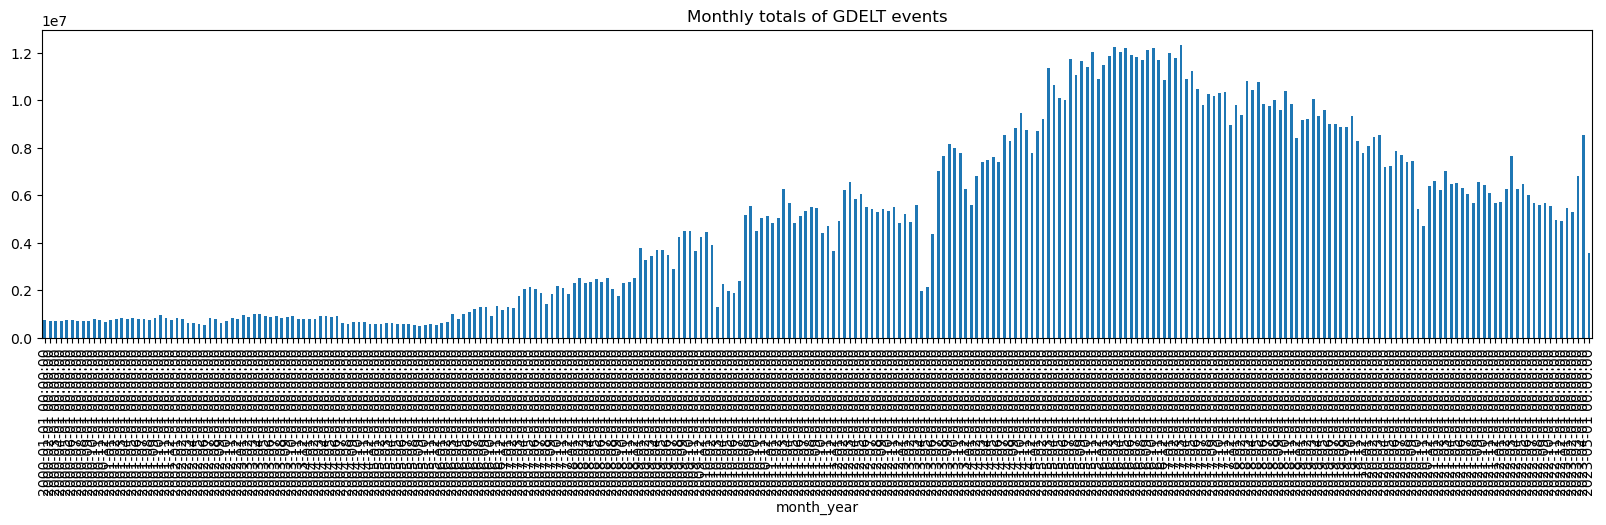

In [81]:
# normalise the events (dividing by the yearly totals)

# plot yearly totals
monthly_totals = df_shares.groupby('month_year')['total_events'].sum()
monthly_totals.plot.bar(figsize=(20, 4), title='Monthly totals of GDELT events')

# normalise the events (dividing by the yearly totals)
df_shares['norm_total_events'] = df_shares.groupby('month_year')['total_events'].transform(lambda x: x / monthly_totals[x.name])

In [82]:
example_date = '2020-02-01'
afg_jan_2020 = df_shares.loc[(df_shares['isocode'] == 'AFG') & (df_shares['month_year'] == example_date)]['total_events'].astype(int)
all_jan_2020 = monthly_totals[example_date].astype(int)

# print('Total events in Afghanistan in January 2020:', afg_jan_2020)
# print('Total events in all countries in January 2020:', all_jan_2020)

print('Manually normalised total events', afg_jan_2020 / all_jan_2020)
print('Normalised total events from dataframe:')
df_shares.loc[(df_shares['isocode'] == 'AFG') & (df_shares['month_year'] == example_date)]['norm_total_events']

Manually normalised total events 72811    0.008301
Name: total_events, dtype: float64
Normalised total events from dataframe:


72811    0.008301
Name: norm_total_events, dtype: float64

In [85]:
# Drop the original count_events_* columns and total event columns
df_shares.drop(columns=event_cols + event_cols_gov + event_cols_opp, inplace=True)
df_shares.drop(columns=['total_events', 'total_events_gov', 'total_events_opp'], inplace=True)

## Generate stocks of events

In [86]:
df_stocks = df_shares.copy()

df_stocks.shape

(55309, 81)

In [87]:
def stock_simple(x: pd.Series, decay: float = 0.8):
    # xs is a stock of x inflow with a decay of 0.8
    # nans = x.isnull()
    x = list(x.fillna(0))
    xs = [] 
    for n in range(len(x)):
        if n == 0: 
            xs.append(x[n]) # stock starts in initial value
        else:
            xs.append(x[n] + decay * xs[n-1])
    #list(np.where(nans, np.nan, xs))
    return xs

def stock_weighted(x: pd.Series, w: pd.Series, decay:float = 0.8):
    # xs is a stock of x inflow, weighted by w, with a decay of 0.8
    x = list(x.fillna(0))
    ws = stock_simple(w) # below this is the number of tokens for that country-month, which the stock_simple function turns into a discounted series
    w = list(w.fillna(0))
    xs = []
    
    for n in range(len(x)):
        if n == 0: 
            xs.append(x[n]) # stock starts in initial value
        else:
            num = w[n]*x[n] + decay * ws[n-1] * xs[n-1]
            
            # word stock for topic = tokens * topic share + decay * past word stock for topic
            # past word stock for topic = total words stock * topic stock share
            
            if ws[n]>0:
                xs.append(num/ws[n])
            else:
                xs.append(num)
    return xs
    

In [88]:
# Create example data frame with a single column of twos
df = pd.DataFrame({'twos': [2] * 10})

# Pass the 'twos' column to the stock_simple function with decay=0.8
result = stock_simple(df['twos'], decay=0.8)

# Print the result
print(result)


[2, 3.6, 4.880000000000001, 5.904000000000001, 6.723200000000001, 7.378560000000001, 7.902848000000001, 8.322278400000002, 8.657822720000002, 8.926258176000001]


In [89]:
#event share stocks
decay = 0.8

unit_of_analyis = 'isocode'

print(df_stocks.shape)

# generates missing values for some months, starting Decemeber 2018 (when using Jan 2018 as start date)
# lcols = (df_feat.groupby(unit_of_analyis)
#         .apply(lambda x: stock_weighted(x['event_share_'+str(t)], x['norm_total_events'], decay=decay))
#         .explode().reset_index(drop=True)
#         .rename('event_share_' + str(t) +'_stock')
#         for t in range(1,21))
# df_feat = df_feat.join(pd.DataFrame(lcols).transpose())

lcols_novs = (df_stocks.groupby(unit_of_analyis)
        .apply(lambda x: stock_simple(x[f'share_events_{t}'], decay=decay))
        .explode().reset_index(drop=True)
        .rename(f'event_share_{t}_stock') for t in range(1,21))

new_df = pd.DataFrame(lcols_novs).transpose()

print(new_df.shape)

df_stocks.reset_index(drop=True, inplace=True)
df_stocks = df_stocks.join(new_df)

print(df_stocks.shape)

new_df.isna().sum().sum()


(55309, 81)
(55309, 20)
(55309, 101)


0

## Admin1 features

Decide between which years to target encode for!


In [90]:
start_encode = 2000
end_encode = 2017 # i.e. train from 2018

In [91]:
df_final = df_stocks.copy()
adm1 = pd.read_csv(parent_path + "/data/final_gdelt_bycountry.txt")

In [92]:
# Dropping columns before 1989 to match the GDELT & UCDP data
adm1.drop(adm1.loc[adm1['year']<start_encode].index, inplace=True)


In [93]:
adm1.sort_values(by=["isocode","year","month","ActionGeo_ADM1Code"])

number_regions = adm1.groupby(["isocode", "year", "month"]).nunique()["ActionGeo_ADM1Code"].reset_index()
number_regions = number_regions.rename({"ActionGeo_ADM1Code": "num_regions"}, axis=1)
number_regions.head(10)

,isocode,year,month,num_regions
0,ABW,2000,2,1
1,ABW,2000,3,1
2,ABW,2000,4,1
3,ABW,2000,6,2
4,ABW,2000,7,1
5,ABW,2000,8,1
6,ABW,2000,9,2
7,ABW,2000,10,2
8,ABW,2000,11,1
9,ABW,2000,12,1


In [94]:
# Merging with the full dataset
df_final['month'] = df_final['month'].astype(int)
df_final = pd.merge(df_final, number_regions, on= ["isocode", "year", "month"], how = "left") # left_on=["isocode", "year", "month"], right_on = ["isocode", "year", "month"]


# check no zeros
(df_final.num_regions.isna().sum()) / len(df_final) 

0.0

In [95]:
# Dropping adm1 that does not have relevant events
# The 'fight' column will contain 1 if there's a non-zero value in any of the columns, otherwise 0

pre_drop = len(adm1)
print('adm1 frame pre drop', pre_drop)

adm1['fight'] = ((adm1['count_events_18'].fillna(0) > 0) | 
                        (adm1['count_events_19'].fillna(0) > 0) | 
                        (adm1['count_events_20'].fillna(0) > 0)).astype(int)

adm1 = adm1[adm1['fight'] == 1] # This will keep only the rows where 'fight' column is equal to 1

post_drop = len(adm1)
print('adm1 frame post drop', post_drop)
print('droped:', pre_drop - post_drop)

adm1 frame pre drop 893047
adm1 frame post drop 561186
droped: 331861


In [96]:
# adm1['year'] = adm1['year'].astype(int)
# adm1['month'] = adm1['month'].astype(int)

adm_full = pd.merge(df_final, adm1[['ActionGeo_ADM1Code',"isocode", "month", "year"]], 
                               left_on=["isocode", "month", "year"], right_on = ["isocode", "month", "year"], 
                               how = "left")


In [97]:
adm_full.head(10)

,MonthYear,isocode,month,year,country,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,...,event_share_13_stock,event_share_14_stock,event_share_15_stock,event_share_16_stock,event_share_17_stock,event_share_18_stock,event_share_19_stock,event_share_20_stock,num_regions,ActionGeo_ADM1Code
0,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF
1,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF01
2,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF02
3,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF05
4,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF08
5,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF09
6,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF11
7,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF13
8,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF18
9,1970-01-01 00:00:00.000200001,AFG,1,2000,Afghanistan,54.0,54.0,0.0,0.0,26.0,...,0.765697,0.612557,0.421133,0.765697,3.407351,0.689127,6.891271,0.0,32,AF23


In [98]:
def encode_adm(df, year_threshold):
    # Split the data into train and test based on the year threshold
    df_train = df[df['year'] <= year_threshold]
    df_test = df[df['year'] > year_threshold]

    # Target encoding the regions that have at least 1 event of type 18, 19, or 20
    region_encoder = ce.TargetEncoder(smoothing=1.0)
    region_encoder.fit(df_train['ActionGeo_ADM1Code'], df_train['deaths'])
    df_train['ActionGeo_ADM1Code'] = region_encoder.transform(df_train['ActionGeo_ADM1Code'], df_train['deaths'])
    df_test['ActionGeo_ADM1Code'] = region_encoder.transform(df_test['ActionGeo_ADM1Code'], df_test['deaths'])
    df = pd.concat([df_train, df_test])

    # Getting the maximum, mean, and median regions for each month/year and country
    df['Adm1_Max'] = df.groupby(['isocode', 'month', 'year'])['ActionGeo_ADM1Code'].transform('max')
    df['Adm1_Mean'] = df.groupby(['isocode', 'month', 'year'])['ActionGeo_ADM1Code'].transform('mean')
    df['Adm1_Median'] = df.groupby(['isocode', 'month', 'year'])['ActionGeo_ADM1Code'].transform('median')

    df_transform = df.drop_duplicates(['isocode', 'month', 'year']).drop(["ActionGeo_ADM1Code"], axis=1)

    return df_transform


In [99]:
df_admin = encode_adm(adm_full, end_encode) #only keeps years after in train

/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_14478/2258167720.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ActionGeo_ADM1Code'] = region_encoder.transform(df_train['ActionGeo_ADM1Code'], df_train['deaths'])
/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_14478/2258167720.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ActionGeo_ADM1Code'] = region_encoder.transform(df_test['ActionGeo_ADM1Code'], df_test['deaths'])


## Share of death types

In [100]:
df_deaths = df_admin.copy()

print('min total events:', df_deaths['deaths'].min())

min total events: 0.0


In [101]:
specific_deaths = ['state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths']

# Compute the share of each subset of deaths of the total deaths - only when not dividing by zero
for col in specific_deaths:
    df_deaths['share_{}'.format(col)] = np.where((df_deaths['deaths'] > 0) & (df_deaths[col] > 0),
                                                 round(df_deaths[col] / df_deaths['deaths'] * 100, 2), 0)

# Drop the original columns
df_deaths.drop(columns=specific_deaths, inplace=True)

df_deaths.isnull().sum().sum()

0

In [102]:
# option to scroll through all columns generated after merging population data
print((set(df_deaths.columns) - set(pop_options.columns)))

{'deaths_all_intp_pop_pc', 'share_events_6', 'event_share_9_stock', 'event_share_8_stock', 'share_events_11_gov', 'share_events_9', 'share_events_8', 'share_events_12', 'Adm1_Mean', 'share_events_3', 'share_events_20', 'norm_total_events', 'share_events_10_opp', 'share_events_1_gov', 'share_events_7_opp', 'share_events_18', 'share_events_13_gov', 'share_state_deaths', 'share_events_4', 'share_events_15_gov', 'share_events_16_gov', 'event_share_19_stock', 'share_events_6_opp', 'share_events_16_opp', 'event_share_5_stock', 'share_events_5_gov', 'past12', 'share_events_16', 'past120', 'event_share_18_stock', 'event_share_10_stock', 'share_events_20_gov', 'event_share_14_stock', 'event_share_12_stock', 'share_events_9_opp', 'event_share_4_stock', 'share_events_7_gov', 'event_share_13_stock', 'share_events_18_gov', 'share_events_10', 'share_events_8_gov', 'share_events_6_gov', 'share_events_2_gov', 'share_events_18_opp', 'share_events_17_gov', 'share_events_3_gov', 'share_events_15_opp', 'e

## Cyclical months feature

In [104]:
df_cyclical = df_deaths.copy()

encoder = CyclicalFeatures(variables=['month'], drop_original=True)
df_cyclical = encoder.fit_transform(df_cyclical)
df_cyclical

,MonthYear,isocode,year,country,deaths,month_year,Country Name,intp_pop,deaths_all_intp_pop_pc,armedconf_intp_pop,...,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,share_state_deaths,share_nonstate_deaths,share_onesided_deaths,share_civilian_deaths,month_sin,month_cos
0,1970-01-01 00:00:00.000200001,AFG,2000,Afghanistan,54.0,2000-01-01,Afghanistan,19542982.0,0.276314,True,...,32,6.403298e+02,6.029093e+02,602.123846,100.0,0.0,0.0,48.15,0.5,0.866025
20,1970-01-01 00:00:00.000200001,AGO,2000,Angola,36.0,2000-01-01,Angola,16394062.0,0.219592,True,...,20,6.128571e+01,2.868255e+01,26.900901,0.0,0.0,100.0,100.00,0.5,0.866025
39,1970-01-01 00:00:00.000200001,ALB,2000,0,0.0,2000-01-01,Albania,3089027.0,0.000000,False,...,14,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.00,0.5,0.866025
51,1970-01-01 00:00:00.000200001,ARE,2000,0,0.0,2000-01-01,United Arab Emirates,3275333.0,0.000000,False,...,8,1.298701e-02,8.923573e-03,0.009028,0.0,0.0,0.0,0.00,0.5,0.866025
55,1970-01-01 00:00:00.000200001,ARG,2000,0,0.0,2000-01-01,Argentina,37070774.0,0.000000,False,...,19,2.648402e-10,3.310646e-11,0.000000,0.0,0.0,0.0,0.00,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555790,1970-01-01 00:00:00.000202305,XKX,2023,0,0.0,2023-05-01,Kosovo,1786038.0,0.000000,False,...,10,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.00,0.5,-0.866025
555793,1970-01-01 00:00:00.000202305,YEM,2023,0,0.0,2023-05-01,"Yemen, Rep.",32981641.0,0.000000,False,...,20,2.178234e+02,1.388658e+02,134.351857,0.0,0.0,0.0,0.00,0.5,-0.866025
555807,1970-01-01 00:00:00.000202305,ZAF,2023,0,0.0,2023-05-01,South Africa,59392255.0,0.000000,False,...,11,3.418803e-02,2.011180e-02,0.018519,0.0,0.0,0.0,0.00,0.5,-0.866025
555818,1970-01-01 00:00:00.000202305,ZMB,2023,0,0.0,2023-05-01,Zambia,19473125.0,0.000000,False,...,11,6.779661e-02,4.572169e-02,0.044444,0.0,0.0,0.0,0.00,0.5,-0.866025


## Export to csv

In [106]:
df = df_cyclical.copy()

print('pop choice:', pop_choice)
print('conflict choice:', conflict_choice)
print('deaths choice:', deaths_choice)


df.drop(columns=['country', pop_choice], inplace=True)

df.head(10)

pop choice: intp_pop
conflict choice: armedconf_intp_pop
deaths choice: deaths_all_intp_pop_pc


,MonthYear,isocode,year,deaths,month_year,Country Name,deaths_all_intp_pop_pc,armedconf_intp_pop,past6,past12,...,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,share_state_deaths,share_nonstate_deaths,share_onesided_deaths,share_civilian_deaths,month_sin,month_cos
0,1970-01-01 00:00:00.000200001,AFG,2000,54.0,2000-01-01,Afghanistan,0.276314,True,0.276314,0.276314,...,32,6.403298e+02,6.029093e+02,602.123846,100.0,0.0,0.0,48.15,0.5,0.866025
20,1970-01-01 00:00:00.000200001,AGO,2000,36.0,2000-01-01,Angola,0.219592,True,0.219592,0.219592,...,20,6.128571e+01,2.868255e+01,26.900901,0.0,0.0,100.0,100.00,0.5,0.866025
39,1970-01-01 00:00:00.000200001,ALB,2000,0.0,2000-01-01,Albania,0.000000,False,0.000000,0.000000,...,14,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.00,0.5,0.866025
51,1970-01-01 00:00:00.000200001,ARE,2000,0.0,2000-01-01,United Arab Emirates,0.000000,False,0.000000,0.000000,...,8,1.298701e-02,8.923573e-03,0.009028,0.0,0.0,0.0,0.00,0.5,0.866025
55,1970-01-01 00:00:00.000200001,ARG,2000,0.0,2000-01-01,Argentina,0.000000,False,0.000000,0.000000,...,19,2.648402e-10,3.310646e-11,0.000000,0.0,0.0,0.0,0.00,0.5,0.866025
63,1970-01-01 00:00:00.000200001,ARM,2000,0.0,2000-01-01,Armenia,0.000000,False,0.000000,0.000000,...,11,2.680412e-01,2.033795e-01,0.193939,0.0,0.0,0.0,0.00,0.5,0.866025
68,1970-01-01 00:00:00.000200001,ATG,2000,0.0,2000-01-01,Antigua and Barbuda,0.000000,False,0.000000,0.000000,...,1,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.00,0.5,0.866025
69,1970-01-01 00:00:00.000200001,AUS,2000,0.0,2000-01-01,Australia,0.000000,False,0.000000,0.000000,...,9,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.00,0.5,0.866025
77,1970-01-01 00:00:00.000200001,AUT,2000,0.0,2000-01-01,Austria,0.000000,False,0.000000,0.000000,...,9,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.00,0.5,0.866025
81,1970-01-01 00:00:00.000200001,AZE,2000,0.0,2000-01-01,Azerbaijan,0.000000,False,0.000000,0.000000,...,28,5.183741e+01,8.988681e+00,0.407647,0.0,0.0,0.0,0.00,0.5,0.866025


In [110]:
df.loc[df['isocode'] == 'DEU', ['month_year', 'month_sin', 'month_cos']].head(14)

,month_year,month_sin,month_cos
294,2000-01-01,5.000000e-01,8.660254e-01
1670,2000-02-01,8.660254e-01,5.000000e-01
3019,2000-03-01,1.000000e+00,6.123234e-17
4342,2000-04-01,8.660254e-01,-5.000000e-01
5657,2000-05-01,5.000000e-01,-8.660254e-01
6973,2000-06-01,1.224647e-16,-1.000000e+00
8330,2000-07-01,-5.000000e-01,-8.660254e-01
9675,2000-08-01,-8.660254e-01,-5.000000e-01
11009,2000-09-01,-1.000000e+00,-1.836970e-16
12328,2000-10-01,-8.660254e-01,5.000000e-01


In [107]:
df.to_csv(path + "/preprocessed_df.csv", index=False)